In [1]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle as rect
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [7]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)


def lim_params(CO_model):
    cosmo_fid = dict(cosmo_input_camb={'H0':67.36,'ombh2':0.02237,'omch2':0.12,
                      'As':2.1e-9,'ns':0.9649,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
    nu=115.271*u.GHz
    
    zObs=3
    Dz=1
    if CO_model=='COMAP':
        nuObs,Dnu=Dnu_from_Dz(nu,zObs,Dz)
        model_params = dict(nu=115.271*u.GHz, nuObs=nuObs,
                            sigma_scatter=0.42,
                            hmf_model='ST',
                            bias_model='ST99',
                            model_type='ML',
                            Mmin = 1e10*u.Msun, Mmax=1e15*u.Msun,
                            model_par={'A':-2.85,'B':-0.42,'C':10**10.63,'Ms':10**12.3*u.Msun},
                            model_name='COMAP_Fid',
                            do_onehalo=True, do_RSD=True, smooth=True,
                            kmin=1e-5*u.Mpc**-1, kmax=100*u.Mpc**-1,
                            nk=500, nmu=50, nM=1000,
                            Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                           dndL_Lcut=20*u.Lsun)
        obs_params = dict(Delta_nu=Dnu, dnu=31.25*u.MHz,
                          Tsys_NEFD=45*u.K/(69.4)**0.5, #We get the improvement here as an efficient way
                          Nfeeds=19*2,
                          beam_FWHM=4.5*u.arcmin,
                          tobs=1000*u.hr,
                          Omega_field=4*u.deg**2,
                          Nfield=1)
    elif CO_model=='Li2016':
        nuObs,Dnu=Dnu_from_Dz(nu,zObs,Dz)
        model_params = dict(nu=115.271*u.GHz, nuObs=nuObs,
                            sigma_scatter=0.3,
                            hmf_model='ST',
                            bias_model='ST99',
                            model_type='ML',
                            Mmin = 1e10*u.Msun, Mmax=1e15*u.Msun,
                            model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':'/home-2/gsatopo1@jhu.edu/library/lim/SFR_tables/UM_sfr.dat','sig_SFR':0.3},
                            model_name='TonyLi',
                            do_onehalo=True, do_RSD=True, smooth=True,
                            kmin=1e-5*u.Mpc**-1, kmax=100*u.Mpc**-1,
                            nk=500, nmu=1000, nM=1000,
                            Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                           dndL_Lcut=20*u.Lsun)
        obs_params = dict(Delta_nu=Dnu, dnu=15.6*u.MHz,
                          Tsys_NEFD=40*u.K, #We get the improvement here as an efficient way
                          Nfeeds=95,
                          beam_FWHM=4*u.arcmin,
                          tobs=9000*u.hr,
                          Omega_field=2.25*u.deg**2,
                          Nfield=4)
        
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

In [8]:
m_Li2016=lim(lim_params('Li2016'))
m_COMAP=lim(lim_params('COMAP'))

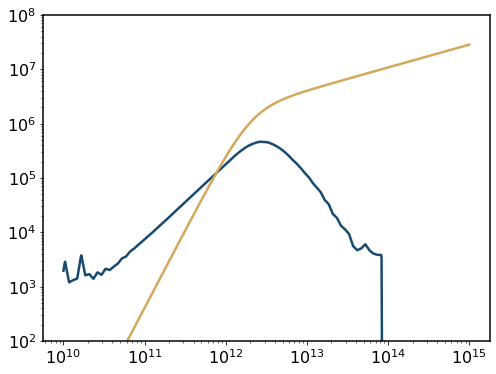

In [84]:
plt.loglog(m_Li2016.M, m_Li2016.LofM)
plt.loglog(m_COMAP.M, m_COMAP.LofM)
plt.ylim(1e2, 1e8)
plt.show()

In [2]:
def LC_params():
    h=0.678
    nu_CO=115.271*u.GHz
    zmin_CO = 2;zmax_CO = 2.8
    zmid_CO=(zmax_CO+zmin_CO)/2
    R=700
    dnu=nu_CO/(1+zmid_CO)/R
    model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                      lines=dict(CO_J10=True), target_line = 'CO_J10',
                      models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                              model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0})),
                      LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, std_log10Ms_IRX=0.17, std_alpha_IRX=0.17,
                                      K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      supersample=1,
                      Nmu=20,
                      dk=0.02*u.Mpc**-1,
                      do_intensity=False,
                      seed=0)
    obs_params=dict(zmin = zmin_CO-0.03, zmax = zmax_CO+0.03,
                    RAObs_min=-5*u.deg,RAObs_max=5*u.deg,
                    DECObs_min=-5*u.deg,DECObs_max=5*u.deg,
                    RA_min=-5*u.deg,RA_max=5*u.deg,
                    DEC_min=-5*u.deg,DEC_max=5*u.deg,
                    nuObs_max=nu_CO/(1+zmin_CO), nuObs_min=nu_CO/(1+zmax_CO),
                    dnu=dnu,
                    Tsys=0*u.Jy/u.sr,
                    #Tsys=0*u.K,
                    #Tsys=(45*u.K/(69.4)**0.5)*np.sqrt(4/400),
                    Nfeeds=19*2,
                    beam_FWHM=2*u.arcmin,
                    tobs=1000*u.hr,
                    do_angular_smooth=False)
    obs_params.update(model_params)

    return obs_params

In [3]:
LC_CO=make_measurements(LC_params())

In [4]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC
inds_redshift=(LC_CO.nuObs_line_halo['CO_J10'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)
inds_SFR=(LC_CO.halo_catalog['SFR_HALO']>0)

inds = inds_SFR&inds_redshift&inds_sky

SM=LC_CO.halo_catalog['SM_HALO'][inds]
SFR=LC_CO.halo_catalog['SFR_HALO'][inds]

log10Ms_IRX,alpha_IRX=9.15, 0.97
std_log10Ms_IRX,std_alpha_IRX=0.17, 0.17
K_IR, K_UV=0.63*1.73e-10, 0.63*2.5e-10

log10Ms_IRX_sample,alpha_IRX_sample = np.random.multivariate_normal(np.asarray([log10Ms_IRX,alpha_IRX]),np.diag(np.asarray([std_log10Ms_IRX**2,std_alpha_IRX])), len(SM)).T
IRX = (SM/10**log10Ms_IRX_sample)**alpha_IRX_sample
LIR = SFR/(K_IR + K_UV/IRX)*u.Lsun
logM=np.log10(LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(u.Msun).value)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_143.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_144.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_145.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_146.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_147.fits


KeyboardInterrupt: 

In [44]:
logM_bin=np.linspace(10.5, 13.5, 41)
meanLIR=[]
meanLIR_old=[]
meanSFR=[]
for i in range(len(logM_bin)-1):
    inds_M = (logM>=logM_bin[i])&(logM<logM_bin[i+1])
    Lbin_IR = LIR[inds_M]
    Lbin_IRold = 1e10 * SFR[inds_M]/1

    SFRbin = SFR[inds_M]
    meanLIR.append(np.mean(Lbin_IR).value)
    meanLIR_old.append(np.mean(Lbin_IRold))
    meanSFR.append(np.mean(SFRbin))

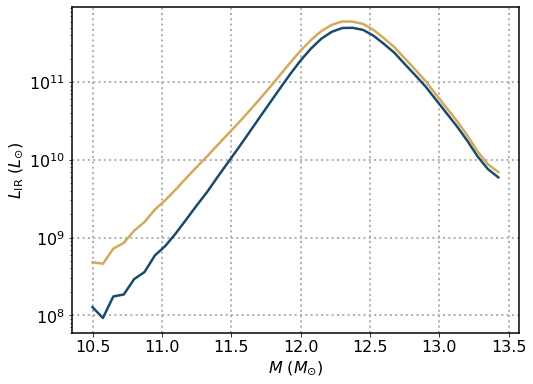

In [45]:
plt.plot(logM_bin[:-1], meanLIR)
plt.plot(logM_bin[:-1], meanLIR_old)
plt.ylabel(r'$L_{\rm IR}$ ($L_{\odot}$)')
plt.xlabel(r'$M$ $(M_{\odot})$')
plt.yscale('log')
plt.grid(linestyle='dotted', linewidth=2)

In [52]:
def LCO_mean(logM, alpha, beta):
    alpha_std, beta_std, sigma_L=0,0,0
    rng=np.random.default_rng(0)
    
    LCO = np.zeros(len(SFR))*u.Lsun

    Lp = 10**((np.log10(LIR.value)-beta)/alpha)
    Lmean = (4.9e-5*u.Lsun)*Lp

    #Add scatter to the relation
    sigma_base_e = sigma_L*2.302585
    LCO = Lmean*rng.lognormal(-0.5*sigma_base_e**2, sigma_base_e, Lmean.shape)
    
    logM_bin=np.linspace(10.5, 13, 41)
    meanLCO=[]
    for i in range(len(logM_bin)-1):
        inds_M = (logM>=logM_bin[i])&(logM<logM_bin[i+1])
        Lbin = LCO[inds_M]
        meanLCO.append(np.mean(Lbin).value)
    return (logM_bin[1:]+logM_bin[:-1])/2, meanLCO

LM_COMAP=interp1d(np.log10(m_COMAP.M.value), m_COMAP.LofM.value)

alpha1, beta1=0.69965366, 4.62740853
alpha2, beta2=0.79460709, 3.64160632

Mbin, LCOmean1=LCO_mean(logM, alpha1, beta1)
Mbin, LCOmean2=LCO_mean(logM, alpha2, beta2)

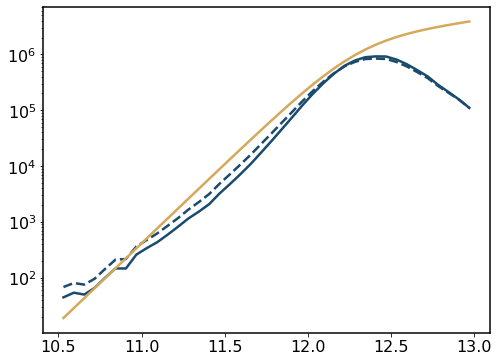

In [54]:
plt.plot(Mbin, LCOmean1, color=palette[0])
plt.plot(Mbin, LCOmean2, '--', color=palette[0])
plt.plot(Mbin, LM_COMAP(Mbin), color=palette[1])
plt.yscale('log')

In [6]:
#DATA 
logLCOdat = np.arange(9.5,11.01,0.1)+0.25
LCOwidth = np.ones((2,len(logLCOdat)))*0.25
logphi_max = np.array([-2.21,-2.69,-2.95,-3.12,-3.24,-3.32,-3.41,-3.37,-3.39,-3.45,-3.60,-3.70,-4.11,-4.25,-4.41,-4.45])
logphi_min = np.array([-4.04,-4.08,-4.14,-4.19,-4.23,-4.10,-4.07,-3.76,-3.69,-3.73,-3.98,-4.10,-4.79,-5.00,-5.44,-6.28])
logphidat = 0.5*(logphi_max+logphi_min)
logphiwidth = np.ones((2,len(logLCOdat)))*0.5*(logphi_max-logphi_min)

In [7]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    # Loop over data points; create box from errors at each point
    errorboxes = [rect((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor, lw=1.5)

    # Add collection to axes
    artists = ax.add_collection(pc)
    ax.plot(0,0)

    return artists

In [13]:
xdata = np.arange(9.5,11.01,0.1)+0.25
ydata_max = np.array([-2.21,-2.69,-2.95,-3.12,-3.24,-3.32,-3.41,-3.37,-3.39,-3.45,-3.60,-3.70,-4.11,-4.25,-4.41,-4.45])
ydata_min = np.array([-4.04,-4.08,-4.14,-4.19,-4.23,-4.10,-4.07,-3.76,-3.69,-3.73,-3.98,-4.10,-4.79,-5.00,-5.44,-6.28])
ydata = 0.5*(ydata_max+ydata_min)
ydata_err = np.ones((len(xdata)))*0.5*(ydata_max-ydata_min)

In [17]:
xdata = np.arange(9.5,11.01,0.5)+0.25
ydata_max = np.array([-2.21,-3.32,-3.60,-4.45])
ydata_min = np.array([-4.04,-4.10,-3.98,-6.28])
ydata = 0.5*(ydata_max+ydata_min)
ydata_err = np.ones((len(xdata)))*0.5*(ydata_max-ydata_min)

In [8]:
def logphi_Lp(logL,a,b):
    print(a,b)
    dlogL=np.asarray([-0.25, +0.25])
    logLp=(np.log10(LIR.value)-b)/a
    logLp_bin=logL[:, None]*np.ones((len(logL),2)) + dlogL[None,:]*np.ones((len(logL),1))

    Nhalos=np.asarray([np.sum((logLp>logLp_bin[i,0])&(logLp<=logLp_bin[i,1])) for i in range(len(logL))])
    phi=Nhalos/0.5/((LC_CO.Lbox[0]*LC_CO.Lbox[1]*LC_CO.Lbox[2]).to(u.Mpc**3))
    #phi=interp1d(x, y.value)
    logphi=np.log10(phi.value)
    return logphi

In [129]:
def gaussian_contour(nsigma, x_dx, corr):
    if nsigma==1:
        chi_sq=2.3
    elif nsigma==2:
        chi_sq=6.17
    u_plus=corr + np.sqrt(4*corr**2 - 4*(x_dx**2 - chi_sq**2*(1-corr**2)))/2
    u_minus=-corr + np.sqrt(4*corr**2 - 4*(x_dx**2 - chi_sq**2*(1-corr**2)))/2

    return u_plus, u_minus
rho=pcov[0,1]/np.sqrt(pcov[0,0]*pcov[1,1])
test1,test2=gaussian_contour(1, 1, rho)
print(beta_fid+test1*beta_std,beta_fid+test2*beta_std)

2.4660162320580734 7.659470173788472


In [112]:
alpha_fid, beta_fid=0.67403184,4.89800039
alpha_std, beta_std=np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1])

logLp_bin=np.linspace(9, 12, 21)
logLp_center=logLp_bin[:-1]+np.diff(logLp_bin)[0]/2

phi_fit=logphi_Lp(logLp_center,alpha_fid, beta_fid)

alphas=alpha+alpha_std*np.linspace(-1,1, 10)
phi_max=[]
phi_min=[]
for i in range(len(alphas)):
    par_plus,par_minus = gaussian_contour(1, (alpha_fid-alphas[i])/alpha_std, rho)
    phi_max.append(logphi_Lp(logLp_center,alphas[i], beta_fid+par_plus*beta_std))
    phi_min.append(logphi_Lp(logLp_center,alphas[i], beta_fid+par_minus*beta_std))

0.67403184 4.89800039
0.45265587759953607 3.465218328698106
0.45265587759953607 8.658672270428506


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


0.5075442736885281 4.227408724209024
0.5075442736885281 9.420862665939424
0.56243266977752 4.6247680781073335
0.56243266977752 9.818222019837734
0.617321065866512 4.835175233128365
0.617321065866512 10.028629174858764
0.6722094619555039 4.904365836147946
0.6722094619555039 10.097819777878346
0.727097858044496 4.843894628817492
0.727097858044496 10.037348570547891
0.7819862541334879 4.643741317785855
0.7819862541334879 9.837195259516253
0.8368746502224799 4.261576929400128
0.8368746502224799 9.455030871130528
0.8917630463114719 3.538942439661662
0.8917630463114719 8.73239638139206


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt


0.9466514424004638 nan
0.9466514424004638 nan


In [40]:
from numpy.random import normal,multivariate_normal

alpha_fid, beta_fid=0.67403184,4.89800039
pcov=np.asarray([[0.0610079,-0.6413858],[-0.6413858,6.74931735]])
alpha_std, beta_std=np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1])

alphas, betas = multivariate_normal(np.array([alpha_fid,beta_fid]),pcov,200).T
mask=(abs(alphas-alpha_fid)<=alpha_std)&(abs(betas-beta_fid)<=beta_std)
alphas=alphas[mask]
betas=betas[mask]

In [41]:
phi_fit=logphi_Lp(logLp_center,alpha_fid, beta_fid)

logLp_bin=np.linspace(9, 12, 21)
logLp_center=logLp_bin[:-1]+np.diff(logLp_bin)[0]/2

logphi_1sig=[]
for i in range(len(alphas)):
    lfunc=logphi_Lp(logLp_center,alphas[i], betas[i])
    logphi_1sig.append(lfunc)

0.67403184 4.89800039
0.6657144904299347 5.035470093894623
0.6741021230756568 4.851546508342157
0.7859966183613816 3.8385198252104025
0.4680138051774425 7.2326726354985595
0.8953860643033437 2.6476850343268916


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


0.7927990084961153 3.6924458094892136
0.5197234151905958 6.478219104677048
0.5593000509470898 6.108987695053833
0.6841482579707515 4.908880802147709
0.8034400730504601 3.5145610923621557
0.5213525410218446 6.5734129029888315
0.5865084335368816 5.911189864130797
0.7028447410791934 4.730070655603468
0.5405486728084004 6.319243110917258
0.798248416386546 3.6292574165297906
0.5548492071674185 6.200687372023188
0.4461059372188109 7.30817964903999
0.46898106102017006 7.0690718889114565
0.6644105144704815 5.008215487707934
0.61792806423974 5.433829510854068
0.7923663660949103 3.584087097401881
0.44839494546118464 7.247309547083164
0.5012772084837699 6.740604359792092
0.8280497912350088 3.211098769260821
0.6458690014226769 5.1564384445564055
0.5798694768699184 5.975370995482995
0.7204287911145029 4.500594503833462
0.4636889463715665 7.114600142639981
0.7991070879012763 3.6412172316681968
0.4628467104962032 7.15324912828632
0.610306375700481 5.606304587109065
0.7127232658764266 4.55491950127267

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


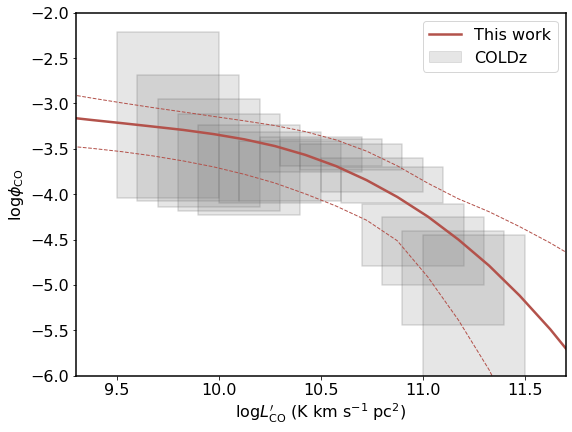

In [54]:
gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(gs[0,0])
_ = make_error_boxes(ax,logLCOdat,logphidat,LCOwidth,logphiwidth,alpha=0.2, facecolor='#828282', edgecolor='#575757')
#ax.errorbar(xdata, ydata, yerr=ydata_err, fmt='o', color=grey)

ax.plot(logLp_center,phi_fit, color='#b3524b', label='This work')
ax.plot(logLp_center,np.max(logphi_1sig, axis=0), '--', lw=1, color='#b3524b')
ax.plot(logLp_center,np.min(logphi_1sig, axis=0), '--', lw=1, color='#b3524b')

handles, labels = ax.get_legend_handles_labels()

coldz = mpatches.Patch(color='#828282', edgecolor='#575757', alpha=0.2, label='COLDz')
handles.append(coldz) 
plt.legend(handles=handles)

plt.ylim(-6,-2)
plt.xlim(9.3,11.7)
plt.xlabel(r'$\log L^{\prime}_{\rm CO}$ (K km s$^{-1}$ pc$^2$)')
plt.ylabel(r'$\log \phi_{\rm CO}$')
plt.savefig('../../Lf_CO.png', dpi=300)

In [90]:
popt, pcov = curve_fit(logphi_Lp, xdata, ydata, p0=[0.5, 6], sigma=ydata_err/2,
                       check_finite=True,
                       method='lm',
                       maxfev=1000,
                       epsfcn=1e-5)
print(popt)
print(pcov)

0.5 6.0
0.5 6.0
0.5 6.0
0.5015811388300842 6.0
0.5 6.018973665961011
1.8817683903846614 -4.138448746254003


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


1.010821286124984 3.14794864886291
0.6935927744355053 5.793878606889739
0.5137776098124561 6.112396784553334
0.5154023172702608 6.112396784553334
0.5137776098124561 6.131725880355212
0.5290005924104475 6.254205066180319
0.5306734391660429 6.254205066180319
0.5290005924104475 6.2739825991432125
0.5481658636692174 6.214017077668498
0.5498993163339655 6.214017077668498
0.5481658636692174 6.233667525053114
0.5661615771655321 6.006873661848887
0.5679519372730483 6.006873661848887
0.5661615771655321 6.025869064237206
0.6042913527391265 5.613364368256638
0.6062022897841264 5.613364368256638
0.6042913527391265 5.631115384996762
0.6808291206425008 4.83155335082096
0.6829820913611007 4.83155335082096
0.6808291206425008 4.846832064046173
0.6094346124270347 5.572391070481583
0.6608726703173542 5.033175146241705
0.6732023327671215 4.903935692843828
0.6773987791487666 4.859969227110601
0.679540902175094 4.859969227110601
0.6773987791487666 4.875337799226599
0.6759153397845943 4.876609438678609
0.677

In [ ]:
[0.67717715 4.86329354]
[[ 0.0610079  -0.6413858 ]
 [-0.6413858   6.74931735]]

In [ ]:
[0.67403184 4.89800039]
[[ 0.06303848 -0.66300452]
 [-0.66300452  6.97952166]]

In [4]:
nu_CO=115.271*u.GHz

LC_CO.update(RAObs_min=-10*u.deg,RAObs_max=10*u.deg,DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
             RA_min=-10*u.deg,RA_max=10*u.deg,DEC_min=-10*u.deg,DEC_max=10*u.deg,
             zmin = 2.5-0.03, zmax = 3.5+0.03,
             nuObs_max=nu_CO/(1+2.5), nuObs_min=nu_CO/(1+3.5),
             models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                     model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0})),
             LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, std_log10Ms_IRX=0.17, std_alpha_IRX=0.17,
                             K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10))

In [5]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (LC_CO.nuObs_line_halo['CO_J10'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)&inds_sky
M_in_survey = LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(u.Msun).value

logMcat_CO=np.log10(M_in_survey)
LCO = LC_CO.halos_in_survey['CO_J10']['Lhalo'].value
logM=np.linspace(np.min(logMcat_CO), np.max(logMcat_CO), 50)

meanLCO=[]
for i in range(len(logM)-1):
    inds = (logMcat_CO>=logM[i])&(logMcat_CO<logM[i+1])&(LCO>0)
    Lbin = LCO[inds]
    meanLCO.append(np.mean(Lbin))

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
LC_CO.update(models=dict(CO_J10=dict(model_name='CO_Li16',
                                     model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})))

In [11]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (LC_CO.nuObs_line_halo['CO_J10'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)&inds_sky
M_in_survey = LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(u.Msun).value

logMcat_CO_Li2016=np.log10(M_in_survey)
LCO_Li2016 = LC_CO.halos_in_survey['CO_J10']['Lhalo'].value
logM=np.linspace(np.min(logMcat_CO), np.max(logMcat_CO), 50)

meanLCO_Li2016=[]
for i in range(len(logM)-1):
    inds = (logMcat_CO_Li2016>=logM[i])&(logMcat_CO_Li2016<logM[i+1])&(LCO_Li2016>0)
    Lbin = LCO_Li2016[inds]
    meanLCO_Li2016.append(np.mean(Lbin))

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


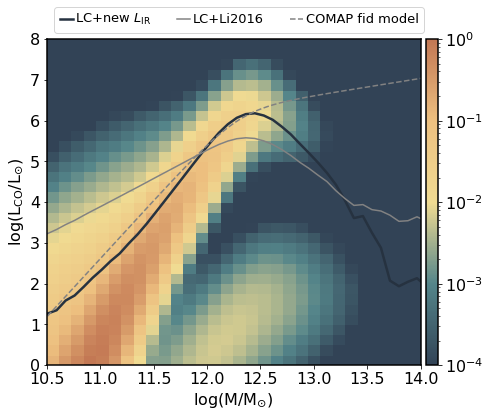

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
im=ax.hist2d(logMcat_CO[LCO>0], np.log10(LCO[LCO>0]), bins=[np.linspace(10.5, 14, 31), np.linspace(0, 7.5, 31)], 
          norm=mpl.colors.LogNorm(), 
          cmap=cmap, density=True, 
          vmin=1e-4, vmax=1)
ax.plot(logM[:-1], np.log10(meanLCO), color='#263240', label=r'LC+new $L_{\rm IR}$')
ax.plot(logM[:-1], np.log10(meanLCO_Li2016), color='#828282', lw=1.5, label=r'LC+Li2016')
ax.plot(np.log10(m_COMAP.M.value), np.log10(m_COMAP.LofM.value), '--', color='#828282', lw=1.5, label=r'COMAP fid model')

ax.set_facecolor(grey)
ax.set_ylim(0, 8)
ax.set_xlim(10.5, 14)
ax.set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
ax.set_xlabel(r'$\log$(M/M$_{\odot}$)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.08)
fig.colorbar(im[3], cax=cax, orientation='vertical')
ax.legend(ncol=3, loc=(0.02,1.02), fontsize=13, handletextpad=0.2, handlelength=1)
plt.savefig('../../LofM.png', dpi=300)

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


Text(0.5, 0, '$\\log$(M/M$_{\\odot}$)')

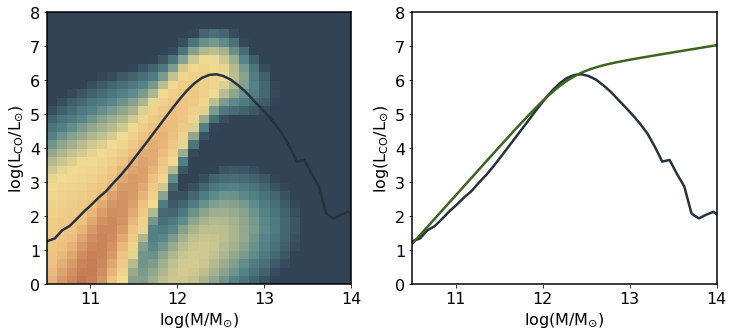

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].hist2d(logMcat_CO[LCO>0], np.log10(LCO[LCO>0]), bins=[np.linspace(10.5, 14, 31), np.linspace(0, 7.5, 31)], 
          norm=mpl.colors.LogNorm(), 
          cmap=cmap, density=True, 
          vmin=1e-4, vmax=1)
ax[0].plot(logM[:-1], np.log10(meanLCO), color='#263240')
ax[0].set_facecolor(grey)
ax[0].set_ylim(0, 8)
ax[0].set_xlim(10.5, 14)
ax[0].set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
ax[0].set_xlabel(r'$\log$(M/M$_{\odot}$)')

ax[1].plot(logM[:-1], np.log10(meanLCO), color='#263240')
ax[1].plot(np.log10(m_COMAP.M.value), np.log10(m_COMAP.LofM.value), color=palette[3])
ax[1].set_ylim(0, 8)
ax[1].set_xlim(10.5, 14)
ax[1].set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
ax[1].set_xlabel(r'$\log$(M/M$_{\odot}$)')

In [60]:
nu_CO=115.271*u.GHz

LC_CO.update(RAObs_min=-10*u.deg,RAObs_max=10*u.deg,DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
             RA_min=-10*u.deg,RA_max=10*u.deg,DEC_min=-10*u.deg,DEC_max=10*u.deg,
             zmin = 2.3-0.03, zmax = 3.3+0.03,
             nuObs_max=nu_CO/(1+2.3), nuObs_min=nu_CO/(1+3.3))

In [89]:
k_IR=LC_CO.k_Pk_poles
Pk_IR=LC_CO.Pk_0

In [91]:
LC_CO.update(models=dict(CO_J10=dict(model_name='CO_Li16',
                                     model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})))

In [92]:
k_Li2016=LC_CO.k_Pk_poles
Pk_Li2016=LC_CO.Pk_0

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


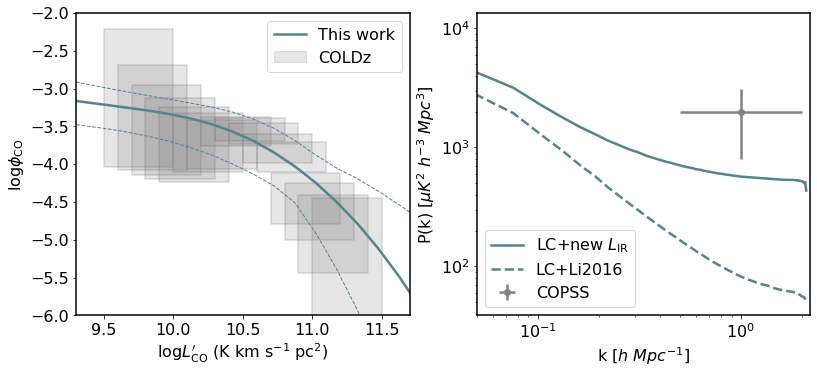

In [135]:
color=turquoise

gs = gridspec.GridSpec(1, 2,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.2,hspace=.0)
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

_ = make_error_boxes(ax0,logLCOdat,logphidat,LCOwidth,logphiwidth,alpha=0.2, facecolor='#828282', edgecolor='#575757')
#ax.errorbar(xdata, ydata, yerr=ydata_err, fmt='o', color=grey)

ax0.plot(logLp_center,phi_fit, color=color, label='This work')
ax0.plot(logLp_center,np.max(logphi_1sig, axis=0), '--', lw=1, color=color)
ax0.plot(logLp_center,np.min(logphi_1sig, axis=0), '--', lw=1, color=color)

handles, labels = ax0.get_legend_handles_labels()

coldz = mpatches.Patch(color='#828282', edgecolor='#575757', alpha=0.2, label='COLDz')
handles.append(coldz) 
ax0.legend(handles=handles)

ax0.set_ylim(-6,-2)
ax0.set_xlim(9.3,11.7)
ax0.set_xlabel(r'$\log L^{\prime}_{\rm CO}$ (K km s$^{-1}$ pc$^2$)')
ax0.set_ylabel(r'$\log \phi_{\rm CO}$')


ax1.loglog(k_IR, Pk_IR, color=color, label=r'LC+new $L_{\rm IR}$')
ax1.loglog(k_Li2016, Pk_Li2016, '--', color=color, label='LC+Li2016')
ax1.errorbar(1, 2e3, xerr=np.array([[0.5,1]]).T, yerr=np.array([[1.2e3,1.1e3]]).T, 
             fmt='o', color='#828282', label='COPSS')
ax1.set_xlabel(r'k [$h\ Mpc^{-1}$]')
ax1.set_ylabel(r'P(k) [$\mu K^2\ h^{-3}\ Mpc^3$]')
ax1.set_xlim(0.05, 2.2)
ax1.legend(loc='lower left')
plt.savefig('../../Lf_Pk_CO.png', dpi=300)

In [69]:
(2-0.5)/2

0.75